# Задача 4. Ансамбли

## Задача

- [x] Найти данные размера хотя бы 10000, на которых можно решить задачу классификации или регрессии.
- [x] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [x] Самостоятельно реализуйте алгоритмы **Bagging** и **AdaBoost**, которые позволят обучить ансамбли каких-то простых моделей, например деревьев принятия решений.
- [x] Обучите ансамбли для каких-то простых моделей, используя свои две реализации, а также реализации из **sklearn** (**Bagging**, **Random Forest**, **AdaBoost**, **Gradient Tree Boosting**, **Histogram-Based Gradient Boosting**).
- [x] При обучении использовать **подбор гиперпараметров**, **кросс-валидацию**.
- [x] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества, построить матрицы ошибок.
- [x] (**+2 балла**) Также добавить в сравнение модели из библиотек **XGBoost**, **LightGBM** и **CatBoost**.
- [x] (**+3 балла**) Для подбора гиперпараметров использовать фреймворк **Optuna**.


In [ ]:
!pip install optuna
!pip install optuna-integration
!pip install catboost

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib

%matplotlib inline
%precision %.4f

dataset_path = pathlib.Path().resolve().parent / "video_games_sales.csv"

# Даннные

Взял [датасет](https://www.kaggle.com/datasets/ulrikthygepedersen/video-games-sales/data) из kaggle.com, на котом будем решать задачу регрессии: определять продажу видеоигр.

Нецелевые признаки:
* **rank** -- индекс
* **name** -- название игры
* **platform** -- платформа, на которой выпускается игра
* **year** -- год выпуска
* **genre** -- жанр
* **publisher** -- издатель видеоигры
* **na_sales** -- продажи в NA регионе
* **eu_sales** -- продажи в EU регионе
* **jp_sales** -- продажи в Японии
* **other_sales** -- продажи в других регионах

В качестве целевого атбрибута будем использовать **global_sales** (суммарные продажи во всех регионах).

In [2]:
df = pd.read_csv('video_games_sales.csv')

In [3]:
df.head()

,rank,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rank          16598 non-null  int64  
 1   name          16598 non-null  object 
 2   platform      16598 non-null  object 
 3   year          16327 non-null  float64
 4   genre         16598 non-null  object 
 5   publisher     16540 non-null  object 
 6   na_sales      16598 non-null  float64
 7   eu_sales      16598 non-null  float64
 8   jp_sales      16598 non-null  float64
 9   other_sales   16598 non-null  float64
 10  global_sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


Имеются нулевые значения в годах и издателе, подчистим.

In [5]:
df = df.dropna(how='any',axis=0)
df = df.drop(df[df.year == 'null'].index)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16291 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rank          16291 non-null  int64  
 1   name          16291 non-null  object 
 2   platform      16291 non-null  object 
 3   year          16291 non-null  float64
 4   genre         16291 non-null  object 
 5   publisher     16291 non-null  object 
 6   na_sales      16291 non-null  float64
 7   eu_sales      16291 non-null  float64
 8   jp_sales      16291 non-null  float64
 9   other_sales   16291 non-null  float64
 10  global_sales  16291 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


После удаления данных с нулевыми значениями в годах, пропали все нулевые значения. Преобразуем объекты типа object, закодировав их в целочисленные значения.

In [7]:
names = list(set(df['name']))
names = dict([(names[i], i) for i in range(len(names))])
df['name'] = [names[r] for r in df.name]

platforms = list(set(df['platform']))
platforms = dict([(platforms[i], i) for i in range(len(platforms))])
df['platform'] = [platforms[r] for r in df.platform]

genres = list(set(df['genre']))
genres = dict([(genres[i], i) for i in range(len(genres))])
df['genre'] = [genres[r] for r in df.genre]

publishers = list(set(df['publisher']))
publishers = dict([(publishers[i], i) for i in range(len(publishers))])
df['publisher'] = [publishers[r] for r in df.publisher]

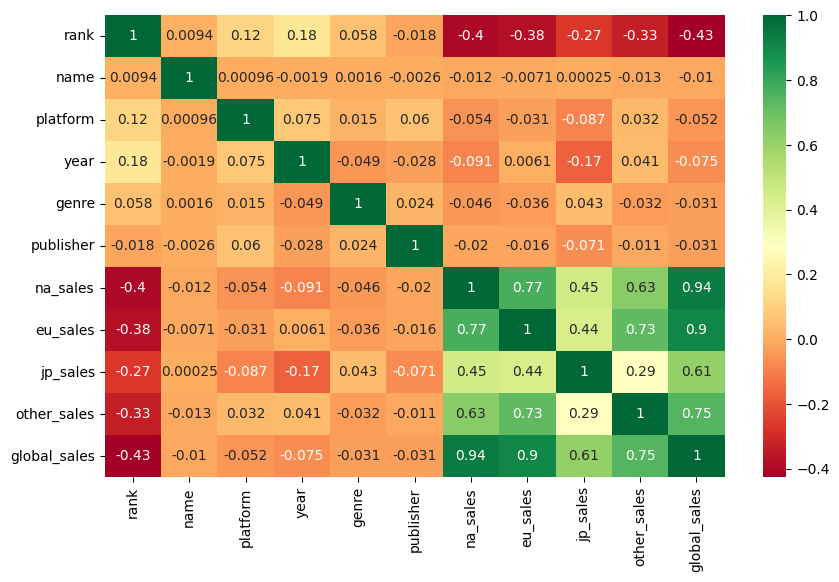

In [8]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10,6)
plt.show()

По достаточно очевидным причинам у нас существует большаня корреляция между продажами в различных регионах и глобальными продажами, т. к. тесно связаны. Удалим количество продаж во всех регионах, кроме глобальных продаж.

In [9]:
df.drop(columns=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], inplace = True)

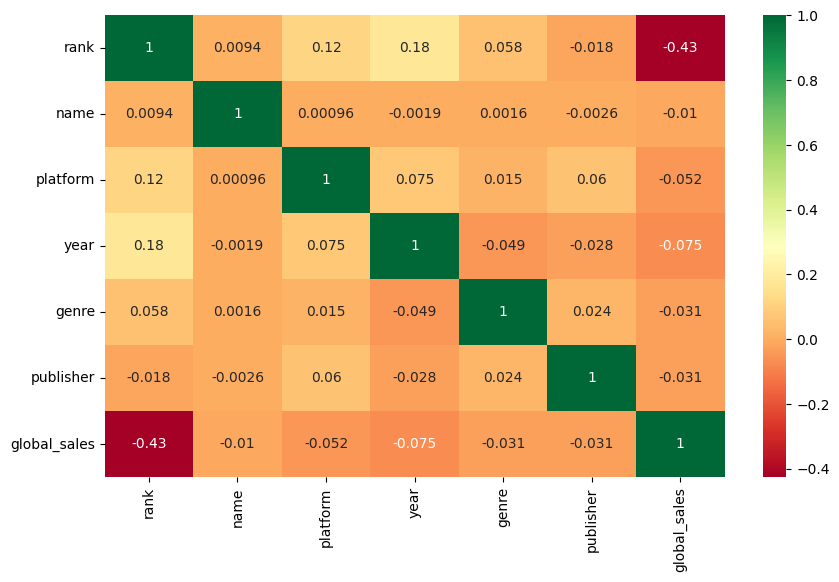

In [10]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10,6)
plt.show()

# Тренировочные данные

In [11]:
df_x = df.drop(columns=['global_sales'])
df_y = df['global_sales']

# Алгоритмы Bagging и AdaBoost

In [20]:
import sklearn
from sklearn.ensemble import BaseEnsemble

np.random.seed(42)

class MyBagging(BaseEnsemble):
    def __init__(self, estimator=None, n_estimators=10, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.random_state = random_state

    def predict(self, x):
        preds = [estimator.predict(x) for estimator in self.estimators_]
        return np.mean(preds, axis=0)

    def fit(self, x, y):
        if self.estimator is not None:
            self.estimator_ = self.estimator
        else:
            self.estimator_ = sklearn.tree.DecisionTreeRegressor()

        self.estimators_ = list()
        for _ in range(self.n_estimators):
            est = sklearn.base.clone(self.estimator_)
            x_r, y_r = sklearn.utils.resample(x, y)
            est.fit(x_r, y_r)
            self.estimators_.append(est)

class MyAdaBoost(BaseEnsemble):
    def __init__(self, estimator=None, n_estimators=50, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.random_state = random_state

    def predict(self, x):
        return np.around(sum((self.alphas[i] * self.estimators_[i].predict(x) for i in range(self.n_estimators))))

    def fit(self, x, y):
        if self.estimator is not None:
            self.estimator_ = self.estimator
        else:
            self.estimator_ = sklearn.tree.DecisionTreeRegressor(max_depth=3)

        self.estimators_ = list()
        self.alphas = [0 for _ in range(self.n_estimators)]
        weight = [1.0 for _ in y]

        for i in range(self.n_estimators):
            est = sklearn.base.clone(self.estimator_)
            est.fit(x, y, weight)
            error = 1 - est.score(x, y, weight)
            self.alphas[i] = np.log((1 - error) / error)
            weight = weight * np.exp(self.alphas[i] * (y != est.predict(x)))
            weight = weight / sum(weight) * len(y)
            self.estimators_.append(est)

        self.alphas /= sum(self.alphas)

# Optuna

In [14]:
import optuna

def train(data, target, estimator, param_distributions):
    study = optuna.create_study(sampler=optuna.samplers.BruteForceSampler(seed=42), direction="maximize")

    search_model = optuna.integration.OptunaSearchCV(
        estimator,
        param_distributions,
        scoring="r2",
        n_jobs=3,
        random_state=42,
        study=study
    )

    results = sklearn.model_selection.cross_validate(
        search_model,
        X = data,
        y = target,
        cv=sklearn.model_selection.KFold(shuffle=True, random_state=42),
        scoring=["r2", "neg_mean_absolute_error"],
        n_jobs=4,
        return_estimator=True,
    )

    for i, estimator in enumerate(results["estimator"], 1):
        print("Best param #{}: {}".format(i, estimator.best_params_))


    results = pd.DataFrame(results)

    results["regressor"] = search_model.estimator.__class__.__name__.removesuffix("Regressor")
    results["test_mae"] = -results["test_neg_mean_absolute_error"]
    results.drop(columns=["test_neg_mean_absolute_error"], inplace=True)
    path = pathlib.Path("optuna_results.csv")
    results.to_csv(path, mode="a", header=not path.exists())

# Обучение
## Bagging

In [15]:
train(
      data = df_x,
      target = df_y,
      estimator=MyBagging(random_state=42),
      param_distributions={
        "n_estimators": optuna.distributions.CategoricalDistribution([10, 50, 100])
    })

# Best param 50

[I 2024-04-07 23:20:46,542] A new study created in memory with name: no-name-d5564286-9f2e-46da-9ad0-ef5271e89429


Best param #1: {'n_estimators': 50}
Best param #2: {'n_estimators': 50}
Best param #3: {'n_estimators': 50}
Best param #4: {'n_estimators': 50}
Best param #5: {'n_estimators': 10}


In [16]:
from sklearn.ensemble import BaggingRegressor

train(
    data = df_x,
    target = df_y,
    estimator=BaggingRegressor(random_state=42, n_jobs=4),
    param_distributions={
        "n_estimators": optuna.distributions.CategoricalDistribution([10, 50, 100])
    }
)

# Best param 100

[I 2024-04-07 23:23:39,053] A new study created in memory with name: no-name-c0a9869d-594b-441d-ae45-dfcd48712fb8


Best param #1: {'n_estimators': 100}
Best param #2: {'n_estimators': 100}
Best param #3: {'n_estimators': 50}
Best param #4: {'n_estimators': 100}
Best param #5: {'n_estimators': 10}


## Boosting

In [21]:
train(
    data = df_x,
    target = df_y,
    estimator=MyAdaBoost(random_state=42),
    param_distributions={
        "n_estimators": optuna.distributions.CategoricalDistribution([10, 50, 100]),
    },
)

# Best param 10

[I 2024-04-07 23:33:05,836] A new study created in memory with name: no-name-931c7a0c-9d45-49f6-af5b-ee94ce79f843


Best param #1: {'n_estimators': 10}
Best param #2: {'n_estimators': 10}
Best param #3: {'n_estimators': 10}
Best param #4: {'n_estimators': 10}
Best param #5: {'n_estimators': 10}


In [22]:
from sklearn.ensemble import AdaBoostRegressor

train(
    data = df_x,
    target = df_y,
    estimator=AdaBoostRegressor(random_state=42),
    param_distributions={
        "n_estimators": optuna.distributions.CategoricalDistribution([10, 50, 100]),
        "learning_rate": optuna.distributions.CategoricalDistribution([0.5, 1, 2]),
    },
)

# 10 0,5

Best param #1: {'n_estimators': 10, 'learning_rate': 0.5}
Best param #2: {'n_estimators': 10, 'learning_rate': 0.5}
Best param #3: {'n_estimators': 10, 'learning_rate': 0.5}
Best param #4: {'n_estimators': 10, 'learning_rate': 0.5}
Best param #5: {'n_estimators': 10, 'learning_rate': 0.5}


In [23]:
from sklearn.ensemble import GradientBoostingRegressor

train(
    data = df_x,
    target = df_y,
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions={
        "n_estimators": optuna.distributions.CategoricalDistribution([10, 50, 100]),
        "learning_rate": optuna.distributions.CategoricalDistribution([0.05, 0.1, 0.2]),
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([10, 1000, None]),
    },
)

#  Best param 50 0,2 10

[I 2024-04-07 23:36:07,329] A new study created in memory with name: no-name-d416491f-e596-45a0-9993-b0f71f38fed4


Best param #1: {'n_estimators': 50, 'learning_rate': 0.2, 'max_leaf_nodes': 10}
Best param #2: {'n_estimators': 50, 'learning_rate': 0.2, 'max_leaf_nodes': 10}
Best param #3: {'n_estimators': 50, 'learning_rate': 0.2, 'max_leaf_nodes': 10}
Best param #4: {'n_estimators': 50, 'learning_rate': 0.2, 'max_leaf_nodes': 10}
Best param #5: {'n_estimators': 100, 'learning_rate': 0.1, 'max_leaf_nodes': 10}


In [24]:
from sklearn.ensemble import HistGradientBoostingRegressor

train(
    data = df_x,
    target = df_y,
    estimator=HistGradientBoostingRegressor(random_state=42, early_stopping=True),
    param_distributions={
        "learning_rate": optuna.distributions.CategoricalDistribution([0.5, 0.1, 0.2]),
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([15, 31, 62, None]),
    },
)

# Best param 0,5 None

[I 2024-04-07 23:38:05,623] A new study created in memory with name: no-name-5047967d-130a-4e10-b463-4f97bc0e6014


Best param #1: {'learning_rate': 0.5, 'max_leaf_nodes': 31}
Best param #2: {'learning_rate': 0.5, 'max_leaf_nodes': None}
Best param #3: {'learning_rate': 0.5, 'max_leaf_nodes': None}
Best param #4: {'learning_rate': 0.5, 'max_leaf_nodes': 62}
Best param #5: {'learning_rate': 0.5, 'max_leaf_nodes': None}


In [25]:
from xgboost import XGBRegressor

train(
    data = df_x,
    target = df_y,
    estimator=XGBRegressor(random_state=42, n_jobs=2),
    param_distributions={
        "tree_method": optuna.distributions.CategoricalDistribution(["exact", "approx", "hist"]),
        "n_estimators": optuna.distributions.CategoricalDistribution([100, 150, 200]),
        "learning_rate": optuna.distributions.CategoricalDistribution([0.1, 0.3, 0.5]),
        "max_leaves": optuna.distributions.CategoricalDistribution([0, 15, 31]),
    },
)

#  exact 100 0,5 31

[I 2024-04-07 23:39:07,912] A new study created in memory with name: no-name-3333ff40-e248-46d6-a040-3ddb38a7b06f


Best param #1: {'tree_method': 'exact', 'n_estimators': 100, 'learning_rate': 0.5, 'max_leaves': 31}
Best param #2: {'tree_method': 'hist', 'n_estimators': 100, 'learning_rate': 0.3, 'max_leaves': 0}
Best param #3: {'tree_method': 'exact', 'n_estimators': 100, 'learning_rate': 0.5, 'max_leaves': 31}
Best param #4: {'tree_method': 'exact', 'n_estimators': 100, 'learning_rate': 0.5, 'max_leaves': 31}
Best param #5: {'tree_method': 'exact', 'n_estimators': 100, 'learning_rate': 0.3, 'max_leaves': 31}


In [26]:
from lightgbm import LGBMRegressor

train(
    data = df_x,
    target = df_y,
    estimator=LGBMRegressor(random_state=42, n_jobs=2),
    param_distributions={
        "n_estimators": optuna.distributions.CategoricalDistribution([50, 100, 150]),
        "learning_rate": optuna.distributions.CategoricalDistribution([0.03, 0.1, 0.3]),
        "num_leaves": optuna.distributions.CategoricalDistribution([15, 31, 62]),
    },
)

#  Best param 50 0,03 31

[I 2024-04-07 23:41:01,343] A new study created in memory with name: no-name-1040c189-dd44-4a8a-add3-9d833c6ea9d8


Best param #1: {'n_estimators': 50, 'learning_rate': 0.3, 'num_leaves': 31}
Best param #2: {'n_estimators': 50, 'learning_rate': 0.3, 'num_leaves': 31}
Best param #3: {'n_estimators': 50, 'learning_rate': 0.3, 'num_leaves': 15}
Best param #4: {'n_estimators': 50, 'learning_rate': 0.3, 'num_leaves': 31}
Best param #5: {'n_estimators': 50, 'learning_rate': 0.3, 'num_leaves': 31}


In [28]:
from catboost import CatBoostRegressor

train(
    data = df_x,
    target = df_y,
    estimator=CatBoostRegressor(random_state=42, thread_count=2),
    param_distributions={
        "n_estimators": optuna.distributions.CategoricalDistribution([50, 100, 200]),
    },
)

#  Best param 200

[I 2024-04-07 23:41:50,058] A new study created in memory with name: no-name-030f01b0-0dde-4de5-b2f0-9005dc944e3c


Best param #1: {'n_estimators': 50}
Best param #2: {'n_estimators': 200}
Best param #3: {'n_estimators': 200}
Best param #4: {'n_estimators': 100}
Best param #5: {'n_estimators': 200}


# Результаты

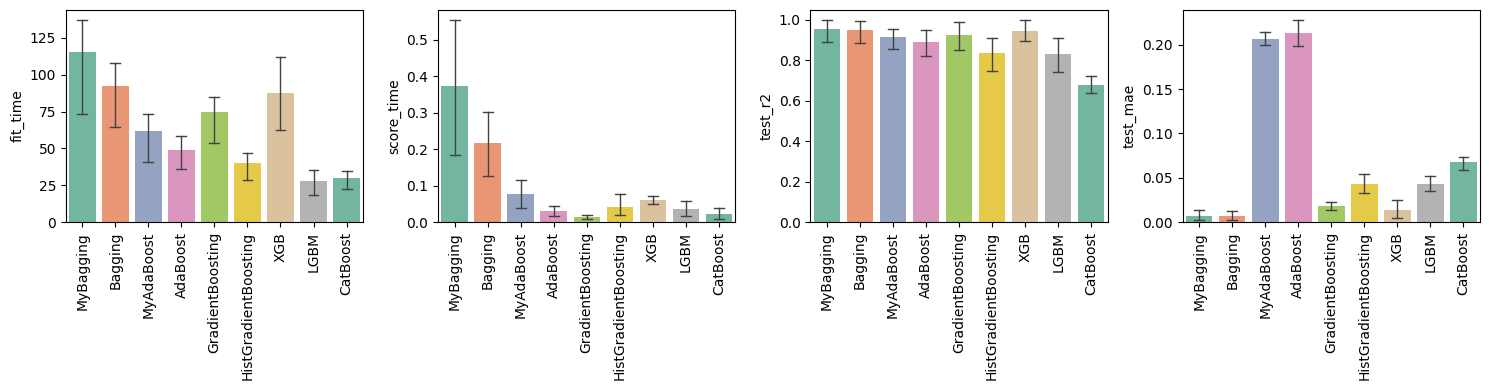

In [29]:
results = pd.read_csv(pathlib.Path("optuna_results.csv"))
fig, axs = plt.subplots(ncols=4, figsize=(15, 4))
colors = sns.color_palette("Set2", len(results["regressor"].unique()))

for idx, (y, ax) in enumerate(zip(["fit_time", "score_time", "test_r2", "test_mae"], axs.flatten())):
    sns.barplot(data=results, x="regressor", y=y, errwidth=1, capsize=0.3, ax=ax, palette={reg: colors[i] for i, reg in enumerate(results["regressor"].unique())})
    ax.tick_params(axis="x", rotation=90)
    ax.set_xlabel(None)

fig.tight_layout()

plt.show()

По построеным графика можно заметить, что результаты достаточно неплохи. Значение показателя MAE не большое, это может быть связано с тем, что значение нашего целевого атрибута находятся в небольшом диапазоне значений (от 0.01 до 82.74).